# Photo Beauty Recognition

## Load Libraries and Functions

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Get and View Image

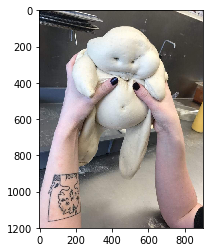

In [5]:
# Works best if it's a jpg
# You can switch this out with the image you want to test. Have the image save locally and reference the path.
image_path = "example_image.jpg" # Uploaded image name

img=mpimg.imread(image_path) # Reading in the image as a matrix of values
plt.imshow(img)
plt.show()

In [6]:
print(img.shape)

(1200, 900, 3)


In [7]:
print(img)

[[[ 32  39  47]
  [ 32  39  47]
  [ 34  41  49]
  ...
  [142 140 151]
  [145 143 154]
  [148 146 157]]

 [[ 34  41  49]
  [ 39  46  54]
  [ 44  51  59]
  ...
  [149 147 158]
  [148 146 157]
  [148 146 157]]

 [[ 36  43  51]
  [ 44  51  59]
  [ 50  57  65]
  ...
  [158 156 167]
  [152 150 161]
  [148 146 157]]

 ...

 [[223 193 201]
  [224 194 202]
  [224 194 202]
  ...
  [ 12  13  17]
  [ 12  13  17]
  [ 12  13  17]]

 [[224 194 202]
  [224 194 202]
  [224 194 202]
  ...
  [ 12  13  17]
  [ 12  13  17]
  [ 12  13  17]]

 [[224 194 202]
  [224 194 202]
  [225 195 203]
  ...
  [ 12  13  17]
  [ 12  13  17]
  [ 12  13  17]]]


## Constants

In [8]:
# Set image size for model
INPUT_HEIGHT=299
INPUT_WIDTH=299
INPUT_COLOR_FLOOR=0 # Range of color values - floor
INPUT_COLOR_CEILING=255 # Range of color values - ceiling

## Functions

In [9]:
# Here down shamelessly taken from https://www.tensorflow.org/tutorials/image_retraining
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

def load_labels(label_file):
    '''Get the list of possible classifications'''
    label = []
    file = open(label_file, "r") 
    proto_as_ascii_lines = file.readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

def get_image_reader_for_image_type(file_reader, file_name):
    '''Takes the file reader and returns the appropriate image reader based on file extension'''
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
    else:
        image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
    return image_reader

def normalize_image_data(image_reader):
    '''Takes an image reader containing info about the image and adjusts datapoints to be consistent'''
    float_caster = tf.cast(image_reader, tf.float32) # Make sure all numbers are floats
    dims_expander = tf.expand_dims(float_caster, 0) # Extra dimension for wiggle room
    resized = tf.image.resize_bilinear(dims_expander, [INPUT_HEIGHT, INPUT_WIDTH]) # resize
    normalized = tf.divide(tf.subtract(resized, [INPUT_COLOR_FLOOR]), [INPUT_COLOR_CEILING]) # Ensure number % of 255
    return normalized

In [10]:
def read_tensor_from_image_file(file_name,):
    '''Creates a tensor to be passed into the model from the image'''
    # Decode the image into an array
    file_reader = tf.read_file(file_name)
    image_reader = get_image_reader_for_image_type(file_reader, file_name)
    normalized = normalize_image_data(image_reader)
    
    sess = tf.Session() # Start a tensorflow session
    result = sess.run(normalized) # Get the normalized tensor that tensorflow can read

    return result

## Tensor and Graph Creation

In [11]:
# Already compiled
graph = load_graph('output_graph.pb')
label_file = load_labels('output_labels.txt')
input_layer = "Placeholder"
output_layer = "final_result"

t = read_tensor_from_image_file(image_path)

# gather layers to input and receive image
input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name) #Represents a graph node that performs computation on tensors.
output_operation = graph.get_operation_by_name(output_name) # Where we want to store the result

## Get Classification

In [13]:
# Start a session with the graph set as the model.
# Get model outputs and use these to compare the model

with tf.Session(graph=graph) as sess:
    results = sess.run(output_operation.outputs[0], {
        input_operation.outputs[0]: t})
    results = np.squeeze(results) #Remove single-dimensional entries from the shape of an array.
    top_k = results.argsort()[-5:][::-1] # Returns the indices that would sort an array. Smallest to biggest.
    labels = label_file
    
    for i in top_k:
        print(labels[i], results[i])   

beautiful 0.69688255
ugly 0.3031174
